# Area Under the Margin on the Adult dataset


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.calibration import LabelEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import shuffle

from mislabeled.detect import ModelProbingDetector
from mislabeled.ensemble import ProgressiveEnsemble
from mislabeled.probe import Logits


class FullMargin:

    def __init__(self, probe):
        self.inner = probe

    def __call__(self, estimator, X, y):
        logits = self.inner(estimator, X, y)
        y = LabelEncoder().fit_transform(y)
        mask = np.zeros_like(logits, dtype=bool)
        mask[np.arange(len(y)), y] = True
        return logits[mask], logits[~mask].reshape(len(y), -1).max(axis=1)


def concat(iterable):
    unzipped = list(zip(*iterable))
    return np.stack(unzipped[0], axis=1), np.stack(unzipped[1], axis=1)


custom_aum = ModelProbingDetector(
    HistGradientBoostingClassifier(
        categorical_features="from_dtype",
        min_samples_leaf=1,
        max_leaf_nodes=None,
        max_depth=10,
        validation_fraction=None,
        learning_rate=0.1,
        max_iter=200,
        random_state=1,
    ),
    ProgressiveEnsemble(staging="predict"),
    FullMargin(Logits()),
    aggregate=concat,
)

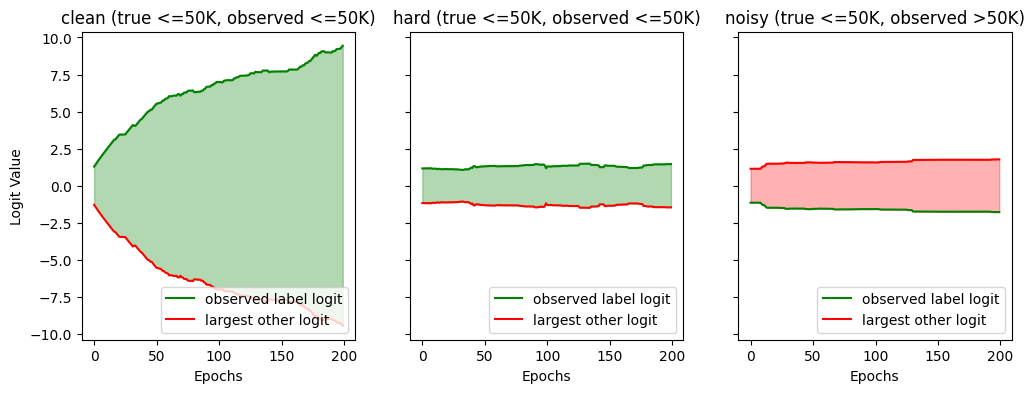

In [5]:
adult = fetch_openml(data_id=1590, as_frame=True)
targets = adult["target"]
features = adult["data"]
features["us-native"] = (features["native-country"] == "United-States").astype(
    "category"
)
features = features.drop(["education-num"], axis=1)
features = features.drop(["native-country"], axis=1)

noisy_targets = shuffle(targets.copy(), random_state=1).reset_index(drop=True)

observed_logits, other_logits = custom_aum.trust_score(features, noisy_targets)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
n_iter = observed_logits.shape[1]
margins = observed_logits - other_logits
aums = np.sum(margins, axis=1)
clean = np.argmax(aums)
noisy = np.argmin(aums)
hard = np.argsort(aums)[int(len(margins) / 2)]
cases = dict(clean=clean, hard=hard, noisy=noisy)
for i, (name, case) in enumerate(cases.items()):
    observed = observed_logits[case]
    other = other_logits[case]
    axes[i].plot(observed, label="observed label logit", color="green")
    axes[i].plot(other, label="largest other logit", color="red")
    axes[i].fill_between(
        np.arange(n_iter),
        observed,
        other,
        color="green",
        alpha=0.3,
        where=observed > other,
    )
    axes[i].fill_between(
        np.arange(n_iter),
        observed,
        other,
        color="red",
        alpha=0.3,
        where=observed < other,
    )
    axes[i].legend(loc="lower right")
    axes[i].set_xlabel("Epochs")
    axes[i].set_title(f"{name} (true {targets[case]}, observed {noisy_targets[case]})")
axes[0].set_ylabel("Logit Value")
plt.show()